# Order feats, std target by meter type

# Imports

In [1]:
%matplotlib inline

import src.utils as udf

import gc
import joblib
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso

import lightgbm as lgb
import xgboost as xgb

# Data

In [2]:
path = '../data/'

In [3]:
train = pd.read_pickle(f'{path}from_mod/train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [4]:
train = udf.reduce_mem_usage(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [5]:
test = pd.read_pickle(f'{path}from_sub/test.pkl')
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
building_id           uint16
meter                 uint8
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             int64
hour                  int64
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            int64
country               object
is_holiday            int64
dtypes: float32(6), int64(4), object(2), uint16(2), uint32(1), uint8(2)
memory usage: 3.5+ GB


In [6]:
test = udf.reduce_mem_usage(test)
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 17 columns):
building_id           uint16
meter                 uint8
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(6), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 2.4+ GB


In [7]:
submission = pd.read_csv(f'{path}raw/test/sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           int64
meter_reading    int64
dtypes: int64(2)
memory usage: 636.3 MB


In [8]:
submission = udf.reduce_mem_usage(submission)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           uint32
meter_reading    uint8
dtypes: uint32(1), uint8(1)
memory usage: 198.8 MB


In [9]:
mb = pd.read_pickle(f'{path}from_sub/mb.pkl')
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          uint32
building_id     uint16
meter           uint8
timestamp       datetime64[ns]
site_id         uint8
primary_use     object
square_feet     uint32
year_built      uint16
missing_year    uint8
dtypes: datetime64[ns](1), object(1), uint16(2), uint32(2), uint8(3)
memory usage: 1.5+ GB


In [10]:
mb = udf.reduce_mem_usage(mb)
mb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 9 columns):
row_id          uint32
building_id     uint16
meter           uint8
timestamp       datetime64[ns]
site_id         uint8
primary_use     object
square_feet     uint32
year_built      uint16
missing_year    uint8
dtypes: datetime64[ns](1), object(1), uint16(2), uint32(2), uint8(3)
memory usage: 1.5+ GB


In [11]:
del path
gc.collect()

66

# Features

In [12]:
train.head()

,building_id,meter,meter_reading,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,46,0,15.604556,19.4,1019.400024,0.0,Retail,9045,2016,0,1,0,0.0,0.000000,100.000000,0,US,1
1,74,0,12.603682,19.4,1019.400024,0.0,Parking,387638,1997,0,1,0,0.0,0.000000,100.000000,0,US,1
2,93,0,15.364478,19.4,1019.400024,0.0,Office,33370,1982,0,1,0,0.0,0.000000,100.000000,0,US,1
3,105,0,23.303600,2.4,1020.900024,3.1,Education,50623,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1
4,106,0,0.374600,2.4,1020.900024,3.1,Education,5374,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1


In [13]:
test.head()

,building_id,meter,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,0,12.8,1022.099976,2.1,Education,7432,2008,0,1,0,-0.642788,0.766044,83.409012,1,US,1
1,1,0,12.8,1022.099976,2.1,Education,2720,2004,0,1,0,-0.642788,0.766044,83.409012,1,US,1
2,2,0,12.8,1022.099976,2.1,Education,5376,1991,0,1,0,-0.642788,0.766044,83.409012,1,US,1
3,3,0,12.8,1022.099976,2.1,Education,23685,2002,0,1,0,-0.642788,0.766044,83.409012,1,US,1
4,4,0,12.8,1022.099976,2.1,Education,116607,1975,0,1,0,-0.642788,0.766044,83.409012,1,US,1


In [14]:
ftrain = ['building_id', 'primary_use', 'square_feet', 'year_built', 'country', 'dayofyear', 'hour', 
         'is_weekend', 'is_holiday', 'rel_humidity', 'dew_temperature', 'sea_level_pressure',
         'wind_speed', 'wind_direction_y', 'meter', 'meter_reading']
ftest = ftrain[:-1]
train = train[ftrain]
test = test[ftest]
test.head()

,building_id,primary_use,square_feet,year_built,country,dayofyear,hour,is_weekend,is_holiday,rel_humidity,dew_temperature,sea_level_pressure,wind_speed,wind_direction_y,meter
0,0,Education,7432,2008,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
1,1,Education,2720,2004,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
2,2,Education,5376,1991,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
3,3,Education,23685,2002,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0
4,4,Education,116607,1975,US,1,0,1,1,83.409012,12.8,1022.099976,2.1,0.766044,0


In [15]:
del ftrain, ftest
gc.collect()

66

# Split data

In [16]:
train_df = []
test_df = []

for m in range(4):
    df_train = train[train.meter == m].drop('meter', axis=1)
    df_train['meter_reading'] *= df_train.square_feet.mean() / df_train.square_feet
    df_train['meter_reading'] = np.log1p(df_train.meter_reading)
    train_df.append(df_train)
    df_test = test[test.meter == m].drop('meter', axis=1)
    test_df.append(df_test)
    print(f'Meter {m}:', df_train.shape, df_test.shape)

Meter 0: (11530268, 15) (24755760, 14)
Meter 1: (3518870, 15) (8724960, 14)
Meter 2: (2296049, 15) (5676480, 14)
Meter 3: (919708, 15) (2540400, 14)


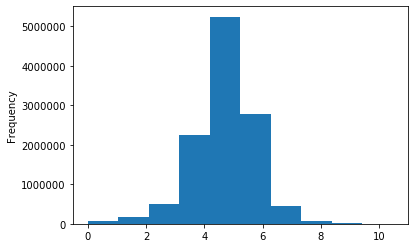

In [17]:
train_df[0].meter_reading.plot(kind='hist')

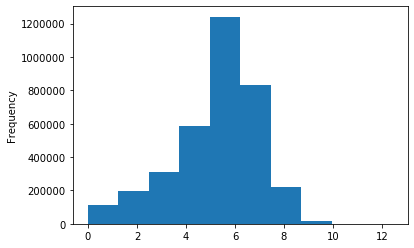

In [18]:
train_df[1].meter_reading.plot(kind='hist')

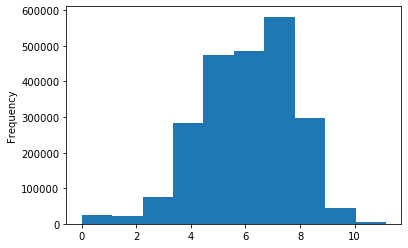

In [19]:
train_df[2].meter_reading.plot(kind='hist')

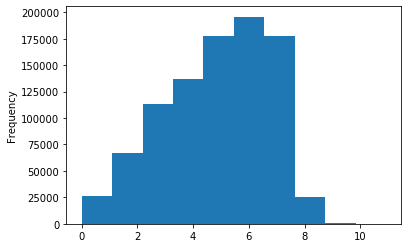

In [20]:
train_df[3].meter_reading.plot(kind='hist')

In [21]:
del m, df_train, df_test
gc.collect()

22

# Functions

In [22]:
def transform_data(df_train, df_test, name_re, name_me, name_ss):
    X_train = df_train.drop('meter_reading', axis=1)
    y_train = df_train[['meter_reading']]
    
    X_train, X_val, X_test, rare_dict = udf.rare_encoder(X_train, df_test, ['primary_use'], name=name_re)
    X_train, X_val, X_test, mean_dict = udf.mean_encoder(X_train, y_train, X_test, ['primary_use', 'country'], name=name_me)
    X_train_scaled, X_val, X_test_scaled = udf.scale_feats(X_train, X_test, name=name_ss)
    
    X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.20, random_state=42)
    
    print('Train: ', X_train_scaled.shape, y_train.shape)
    print('Validation: ', X_val_scaled.shape, y_val.shape)
    print('Test: ', X_test_scaled.shape)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val

In [23]:
def predict_lgb(X_train, y_train, X_val, y_val, X_test, params_dict, save_path):
    dtrain = lgb.Dataset(X_train, label=y_train)
    dval = lgb.Dataset(X_val, label=y_val)
    lgbm = lgb.train(params_dict, dtrain, valid_sets=[dtrain, dval], valid_names=['train', 'val'], verbose_eval=False)
    joblib.dump(lgbm, save_path)
#     lgbm.save_model(save_path)
    
    pred = lgbm.predict(X_test)
    pred[pred < 0] = 0
    return pred

In [24]:
def predict_xgb(X_train, y_train, X_val, y_val, X_test, params_dict, save_path):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    dtest = xgb.DMatrix(X_test)
    xg = xgb.train(params_dict, dtrain, evals=[(dtrain, 'train'), (dval, 'val')], num_boost_round=1000, early_stopping_rounds=10, verbose_eval=False)
    joblib.dump(xg, save_path)
#     xg.save_model(save_path)
    
    pred = xg.predict(dtest)
    pred[pred < 0] = 0
    return pred

In [25]:
gc.collect()

66

# Electricity meter

### Transform data

In [26]:
Xe_train_scaled, Xe_val_scaled, Xe_test_scaled, ye_train, ye_val = transform_data(train_df[0], test_df[0], 'rare_enc0.pkl', 'mean_enc0.pkl', 'scaler0.pkl')
Xe_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (9224214, 14) (9224214, 1)
Validation:  (2306054, 14) (2306054, 1)
Test:  (24755760, 14)


,building_id,primary_use,square_feet,year_built,country,dayofyear,hour,is_weekend,is_holiday,rel_humidity,dew_temperature,sea_level_pressure,wind_speed,wind_direction_y
8660527,0.892008,0.214146,0.269849,0.165854,0.257499,0.865331,-0.361461,-0.633757,-0.180316,0.280494,0.074159,-0.931491,0.448294,-1.332753
22572,1.483336,0.258465,-0.071859,-0.161044,0.257499,-1.782112,0.794318,-0.633757,5.545828,-0.693457,-1.443078,-0.081025,0.448294,-1.424301
6861624,0.734320,0.258465,-0.631217,-0.161044,0.257499,0.341557,1.227735,-0.633757,-0.180316,-1.934299,-0.714804,-0.243020,-0.412867,-0.425474
6413870,0.842730,0.025558,0.343939,-0.114344,-0.603697,0.208232,1.661153,-0.633757,-0.180316,1.207477,0.539445,-0.904498,1.051107,-1.332753
8131131,-0.854876,0.214146,6.771111,1.053146,0.257499,0.712961,-0.505934,-0.633757,-0.180316,0.988530,1.480132,-0.054024,0.233004,-0.169881


### Lasso Regression

In [27]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xe_train_scaled, ye_train)

val0 = lasso.predict(Xe_val_scaled)
print(lasso.score(Xe_val_scaled, ye_val))
print(np.sqrt(mean_squared_log_error(ye_val, val0)))

lasso0 = lasso.predict(Xe_test_scaled)
lasso0[lasso0 < 0] = 0
lasso0

0.09156365220703422
0.21078510262531835


array([4.76556756, 4.74787705, 4.67995548, ..., 4.94256863, 4.67549845,
       4.90934157])

### LightGBM

In [28]:
study_lgb0 = joblib.load('../objects/electricity/study_lgb.pkl')
params_lgb0 = study_lgb0.best_trial.params
params_lgb0

{'learning_rate': 0.07916336777546343,
 'lambda_l1': 0.008557356431137609,
 'lambda_l2': 0.0006037228650908533,
 'max_depth': 51,
 'num_leaves': 923,
 'min_child_samples': 7,
 'subsample': 0.7399597912518232,
 'feature_fraction': 0.7310599981838332}

In [29]:
params_lgb0['num_iterations'] = 10000
params_lgb0['early_stopping_round'] = 10
params_lgb0['metric'] = 'rmse'
params_lgb0['num_threads'] = -1
params_lgb0['seed'] = 42
params_lgb0

{'learning_rate': 0.07916336777546343,
 'lambda_l1': 0.008557356431137609,
 'lambda_l2': 0.0006037228650908533,
 'max_depth': 51,
 'num_leaves': 923,
 'min_child_samples': 7,
 'subsample': 0.7399597912518232,
 'feature_fraction': 0.7310599981838332,
 'num_iterations': 10000,
 'early_stopping_round': 10,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [30]:
lgbm0 = predict_lgb(Xe_train_scaled, ye_train, Xe_val_scaled, ye_val, Xe_test_scaled, params_lgb0, '../objects/submission5/lgb0.pkl')
lgbm0

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([5.52039093, 5.42828297, 2.24426075, ..., 3.90068262, 6.28817936,
       1.66465688])

### XGBoost

In [31]:
study_xgb0 = joblib.load('../objects/electricity/study_xgb.pkl')
params_xgb0 = study_xgb0.best_trial.params
params_xgb0['eval_metric'] = 'rmse'
params_xgb0['seed'] = 42
params_xgb0

{'grow_policy': 'lossguide',
 'learning_rate': 0.014754037383886122,
 'alpha': 0.005261717289274988,
 'lambda': 0.10981652452119427,
 'gamma': 0.00015007710756172543,
 'max_depth': 23,
 'max_leaves': 1598,
 'subsample': 0.8406224713599797,
 'colsample_bytree': 0.9175035245877109,
 'eval_metric': 'rmse',
 'seed': 42}

In [32]:
xg0 = predict_xgb(Xe_train_scaled, ye_train, Xe_val_scaled, ye_val, Xe_test_scaled, params_xgb0, '../objects/submission5/xgb0.pkl')
xg0

[16:55:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


array([4.96423  , 4.944954 , 2.4785538, ..., 4.2183228, 6.253382 ,
       1.5743831], dtype=float32)

In [33]:
del lasso, val0, study_lgb0
gc.collect()

109

# Chilled water meter

### Transform data

In [34]:
Xc_train_scaled, Xc_val_scaled, Xc_test_scaled, yc_train, yc_val = transform_data(train_df[1], test_df[1], 'rare_enc1.pkl', 'mean_enc1.pkl', 'scaler1.pkl')
Xc_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (2815096, 14) (2815096, 1)
Validation:  (703774, 14) (703774, 1)
Test:  (8724960, 14)


,building_id,primary_use,square_feet,year_built,country,dayofyear,hour,is_weekend,is_holiday,rel_humidity,dew_temperature,sea_level_pressure,wind_speed,wind_direction_y
1744059,1.162669,1.674479,0.975336,-0.202419,-0.173847,0.011193,-0.669692,1.599073,-0.170259,1.265604,1.261357,-1.141492,-0.431333,0.517762
1292909,0.884779,0.576989,-0.486890,-0.257998,-0.173847,-0.397031,-1.396167,1.599073,-0.170259,0.162895,0.491998,0.687055,-1.428880,-0.009177
2029936,0.943520,1.674479,0.014556,1.187055,-0.173847,0.260111,0.928554,-0.625362,-0.170259,-0.037984,0.718861,0.671947,0.756222,1.325078
2163727,-0.260670,1.674479,-0.762502,-0.424735,-0.173847,0.389548,1.073849,-0.625362,-0.170259,0.091379,1.320539,0.475493,0.281200,-0.779510
1649192,-1.742749,-0.357065,0.617066,2.076318,-0.173847,-0.078417,-1.105577,-0.625362,-0.170259,1.404484,1.429038,-0.023210,-0.716347,-0.009177


### Lasso Regression

In [35]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xc_train_scaled, yc_train)

val1 = lasso.predict(Xc_val_scaled)
print(lasso.score(Xc_val_scaled, yc_val))
print(np.sqrt(mean_squared_log_error(yc_val, val1)))

lasso1 = lasso.predict(Xc_test_scaled)
lasso1[lasso1 < 0] = 0
lasso1

0.23000358079934125
0.3306327887150343


array([4.5699935 , 4.35789718, 4.6634757 , ..., 5.62115502, 5.3707233 ,
       5.49983763])

### LightGBM

In [36]:
study_lgb1 = joblib.load('../objects/chilledwater/study_lgb1.pkl')
params_lgb1 = study_lgb1.best_trial.params
params_lgb1

{'learning_rate': 0.020424864262841822,
 'lambda_l1': 0.27986455703148144,
 'lambda_l2': 7.08804479307531,
 'max_depth': 32,
 'num_leaves': 1293,
 'min_data_in_leaf': 23,
 'bagging_fraction': 0.9143657877950819,
 'feature_fraction': 0.701556769695671}

In [37]:
params_lgb1['num_iterations'] = 10000
params_lgb1['early_stopping_round'] = 20
params_lgb1['metric'] = 'rmse'
params_lgb1['num_threads'] = -1
params_lgb1['seed'] = 42
params_lgb1

{'learning_rate': 0.020424864262841822,
 'lambda_l1': 0.27986455703148144,
 'lambda_l2': 7.08804479307531,
 'max_depth': 32,
 'num_leaves': 1293,
 'min_data_in_leaf': 23,
 'bagging_fraction': 0.9143657877950819,
 'feature_fraction': 0.701556769695671,
 'num_iterations': 10000,
 'early_stopping_round': 20,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [38]:
lgbm1 = predict_lgb(Xc_train_scaled, yc_train, Xc_val_scaled, yc_val, Xc_test_scaled, params_lgb1, '../objects/submission5/lgb1.pkl')
lgbm1

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([3.80464247, 2.00206245, 2.61865401, ..., 2.96527746, 0.63557749,
       2.04564065])

### XGBoost

In [39]:
study_xgb1 = joblib.load('../objects/chilledwater/study_xgb1.pkl')
params_xgb1 = study_xgb1.best_trial.params
params_xgb1['eval_metric'] = 'rmse'
params_xgb1['seed'] = 42
params_xgb1

{'grow_policy': 'depthwise',
 'learning_rate': 0.03801178677708901,
 'alpha': 0.051064916441743415,
 'lambda': 0.890189928673286,
 'gamma': 0.053083931710043705,
 'max_depth': 16,
 'max_leaves': 1131,
 'subsample': 0.7245353487626778,
 'colsample_bytree': 0.777530288110325,
 'eval_metric': 'rmse',
 'seed': 42}

In [40]:
xg1 = predict_xgb(Xc_train_scaled, yc_train, Xc_val_scaled, yc_val, Xc_test_scaled, params_xgb1, '../objects/submission5/xgb1.pkl')
xg1

array([3.850196 , 2.307846 , 2.6529038, ..., 2.9627392, 1.1368375,
       2.9114306], dtype=float32)

In [41]:
del lasso, val1, study_lgb1
gc.collect()

109

# Steam meter

### Transform data

In [42]:
Xs_train_scaled, Xs_val_scaled, Xs_test_scaled, ys_train, ys_val = transform_data(train_df[2], test_df[2], 'rare_enc2.pkl', 'mean_enc2.pkl', 'scaler2.pkl')
Xs_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (1836839, 14) (1836839, 1)
Validation:  (459210, 14) (459210, 1)
Test:  (5676480, 14)


,building_id,primary_use,square_feet,year_built,country,dayofyear,hour,is_weekend,is_holiday,rel_humidity,dew_temperature,sea_level_pressure,wind_speed,wind_direction_y
2270775,-1.117975,-0.544919,0.931530,-0.152204,0.181765,1.641147,-0.072679,-0.631491,-0.177586,0.685238,1.095753,0.412020,-0.024691,0.677522
1376356,-1.209021,-1.240523,-0.801729,0.118055,0.181765,0.363790,0.651112,1.583553,-0.177586,-0.744683,1.345476,-1.219827,-0.024691,-0.248520
1723076,1.325099,0.963477,-0.731244,-0.219768,0.181765,0.885922,-1.665020,1.583553,-0.177586,1.309187,0.551715,0.439916,1.137738,0.321329
625779,-0.748732,-0.544919,0.491304,-0.152204,0.181765,-0.773710,1.664420,-0.631491,-0.177586,1.281103,0.649821,0.007542,-1.410663,0.036405
1803811,-1.097743,-0.544919,-0.204896,-0.152204,0.181765,1.007131,0.216837,-0.631491,-0.177586,-1.763980,-0.036916,0.942019,0.198853,0.036405


### Lasso Regression

In [43]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xs_train_scaled, ys_train)

val2 = lasso.predict(Xs_val_scaled)
print(lasso.score(Xs_val_scaled, ys_val))
print(np.sqrt(mean_squared_log_error(ys_val, val2)))

lasso2 = lasso.predict(Xs_test_scaled)
lasso2[lasso2 < 0] = 0
lasso2

0.3414665073504983
0.25384089653954856


array([6.04341438, 6.02659764, 6.02552573, ..., 6.24241185, 6.19060251,
       6.57503667])

### LightGBM

In [44]:
study_lgb2 = joblib.load('../objects/steam/study_lgb2.pkl')
params_lgb2 = study_lgb2.best_trial.params
params_lgb2

{'learning_rate': 0.04854268157540762,
 'lambda_l1': 0.0028266466239996284,
 'lambda_l2': 0.00010211303918218761,
 'max_depth': 56,
 'num_leaves': 409,
 'min_data_in_leaf': 8,
 'bagging_fraction': 0.5012612103606688,
 'feature_fraction': 0.8537936823847498}

In [45]:
params_lgb2['num_iterations'] = 10000
params_lgb2['early_stopping_round'] = 20
params_lgb2['metric'] = 'rmse'
params_lgb2['num_threads'] = -1
params_lgb2['seed'] = 42
params_lgb2

{'learning_rate': 0.04854268157540762,
 'lambda_l1': 0.0028266466239996284,
 'lambda_l2': 0.00010211303918218761,
 'max_depth': 56,
 'num_leaves': 409,
 'min_data_in_leaf': 8,
 'bagging_fraction': 0.5012612103606688,
 'feature_fraction': 0.8537936823847498,
 'num_iterations': 10000,
 'early_stopping_round': 20,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [46]:
lgbm2 = predict_lgb(Xs_train_scaled, ys_train, Xs_val_scaled, ys_val, Xs_test_scaled, params_lgb2, '../objects/submission5/lgb2.pkl')
lgbm2

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([5.72501984, 6.61508621, 9.80275593, ..., 6.33472452, 6.25173878,
       3.29156439])

### XGBoost

In [47]:
study_xgb2 = joblib.load('../objects/steam/study_xgb2.pkl')
params_xgb2 = study_xgb2.best_trial.params
params_xgb2['eval_metric'] = 'rmse'
params_xgb2['seed'] = 42
params_xgb2

{'grow_policy': 'depthwise',
 'learning_rate': 0.045664576584020004,
 'alpha': 1.9071087639650297,
 'lambda': 0.00021496551872384197,
 'gamma': 0.15536767802205387,
 'max_depth': 59,
 'max_leaves': 1626,
 'subsample': 0.926581683911481,
 'colsample_bytree': 0.8620824662132568,
 'eval_metric': 'rmse',
 'seed': 42}

In [48]:
xg2 = predict_xgb(Xs_train_scaled, ys_train, Xs_val_scaled, ys_val, Xs_test_scaled, params_xgb2, '../objects/submission5/xgb2.pkl')
xg2

array([5.4265337, 6.42295  , 9.790721 , ..., 6.4540777, 6.3022256,
       3.2595406], dtype=float32)

In [49]:
del lasso, val2, study_lgb2
gc.collect()

109

# Hot water meter

### Transform data

In [50]:
Xh_train_scaled, Xh_val_scaled, Xh_test_scaled, yh_train, yh_val = transform_data(train_df[3], test_df[3], 'rare_enc3.pkl', 'mean_enc3.pkl', 'scaler3.pkl')
Xh_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


Train:  (735766, 14) (735766, 1)
Validation:  (183942, 14) (183942, 1)
Test:  (2540400, 14)


,building_id,primary_use,square_feet,year_built,country,dayofyear,hour,is_weekend,is_holiday,rel_humidity,dew_temperature,sea_level_pressure,wind_speed,wind_direction_y
531429,0.880424,1.104583,0.413464,-0.002246,0.020743,0.231231,-1.230108,-0.630965,-0.182612,1.190757,1.363988,0.725615,-1.499733,0.123194
839174,-1.187059,-1.825934,-0.522012,2.041007,0.020743,1.458709,-0.650125,1.584873,-0.182612,0.300659,-0.542300,0.236225,-1.499733,0.123194
575420,-1.125785,-0.530918,0.606168,0.052977,0.020743,0.411742,1.669805,-0.630965,-0.182612,0.006423,1.481792,-0.663190,-0.491911,-1.119425
65167,-1.115902,-1.825934,-0.102258,-0.388808,0.020743,-1.402399,-1.085112,-0.630965,-0.182612,-0.886622,-0.895713,0.752062,-1.499733,0.123194
529141,0.854729,1.104583,-0.537519,-0.002246,0.020743,0.222205,-1.520099,-0.630965,-0.182612,0.443394,1.117670,0.871105,-1.499733,0.123194


### Lasso Regression

In [51]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xh_train_scaled, yh_train)

val3 = lasso.predict(Xh_val_scaled)
print(lasso.score(Xh_val_scaled, yh_val))
print(np.sqrt(mean_squared_log_error(yh_val, val3)))

lasso3 = lasso.predict(Xh_test_scaled)
lasso3[lasso3 < 0] = 0
lasso3

0.3416840763511245
0.35675692976189866


array([5.13264981, 5.11066832, 5.14505069, ..., 5.31785285, 5.2427731 ,
       5.09224372])

### LightGBM

In [52]:
study_lgb3 = joblib.load('../objects/hotwater/study_lgb3.pkl')
params_lgb3 = study_lgb3.best_trial.params
params_lgb3

{'learning_rate': 0.023942434668217872,
 'lambda_l1': 0.23828824891615835,
 'lambda_l2': 0.00028375734074312625,
 'max_depth': 58,
 'num_leaves': 1581,
 'min_data_in_leaf': 42,
 'bagging_fraction': 0.500825513633077,
 'feature_fraction': 0.9607308095583501}

In [53]:
params_lgb3['num_iterations'] = 10000
params_lgb3['early_stopping_round'] = 20
params_lgb3['metric'] = 'rmse'
params_lgb3['num_threads'] = -1
params_lgb3['seed'] = 42

In [54]:
lgbm3 = predict_lgb(Xh_train_scaled, yh_train, Xh_val_scaled, yh_val, Xh_test_scaled, params_lgb3, '../objects/submission5/lgb3.pkl')
lgbm3

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([5.02921577, 5.17982777, 5.67358819, ..., 7.86767093, 5.51312258,
       7.85699934])

### XGBoost

In [55]:
study_xgb3 = joblib.load('../objects/hotwater/study_xgb3.pkl')
params_xgb3 = study_xgb3.best_trial.params
params_xgb3['eval_metric'] = 'rmse'
params_xgb3['seed'] = 42
params_xgb3

{'grow_policy': 'lossguide',
 'learning_rate': 0.009806612868641755,
 'alpha': 0.009923410545051567,
 'lambda': 2.4314911765779557,
 'gamma': 0.00182351994095809,
 'max_depth': 51,
 'max_leaves': 1225,
 'subsample': 0.8446420358715253,
 'colsample_bytree': 0.8798084029338699,
 'eval_metric': 'rmse',
 'seed': 42}

In [56]:
xg3 = predict_xgb(Xh_train_scaled, yh_train, Xh_val_scaled, yh_val, Xh_test_scaled, params_xgb3, '../objects/submission5/xgb3.pkl')
xg3

array([5.2769165, 5.090896 , 5.7404056, ..., 7.876289 , 5.439945 ,
       7.778914 ], dtype=float32)

In [57]:
del lasso, val3, study_lgb3
gc.collect()

109

# Combine predictions

In [58]:
print('Test observations: ', [df.shape[0] for df in test_df])
print('Lasso predictions: ', list(map(len, [lasso0, lasso1, lasso2, lasso3])))
print('LightGBM predictions: ', list(map(len, [lgbm0, lgbm1, lgbm2, lgbm3])))
print('XGBoost predictions: ', list(map(len, [xg0, xg1, xg2, xg3])))

Test observations:  [24755760, 8724960, 5676480, 2540400]
Lasso predictions:  [24755760, 8724960, 5676480, 2540400]
LightGBM predictions:  [24755760, 8724960, 5676480, 2540400]
XGBoost predictions:  [24755760, 8724960, 5676480, 2540400]


In [59]:
# Electricity meter
pred0 = test_df[0][['square_feet']].copy()
pred0['lasso'] = np.expm1(lasso0)
pred0['lasso'] *= pred0.square_feet / pred0.square_feet.mean()
pred0['lgb'] = np.expm1(lgbm0)
pred0['lgb'] *= pred0.square_feet / pred0.square_feet.mean()
pred0['xgb'] = np.expm1(xg0)
pred0['xgb'] *= pred0.square_feet / pred0.square_feet.mean()
pred0

,square_feet,lasso,lgb,xgb
0,7432,9.382028,20.048644,11.461633
1,2720,3.372954,6.689255,4.114137
2,5376,6.224949,0.491712,0.636924
3,23685,28.701838,16.710242,82.449435
4,116607,116.304802,47.336918,28.215942
...,...,...,...,...
41697595,19619,19.228044,4.630514,4.487186
41697596,4298,5.344204,4.587699,4.945417
41697597,11265,16.997993,5.917627,8.175799
41697598,29775,34.322148,173.465112,167.521790


In [60]:
# Chilled water meter
pred1 = test_df[1][['square_feet']].copy()
pred1['lasso'] = np.expm1(lasso1)
pred1['lasso'] *= pred1.square_feet / pred1.square_feet.mean()
pred1['lgb'] = np.expm1(lgbm1)
pred1['lgb'] *= pred1.square_feet / pred1.square_feet.mean()
pred1['xgb'] = np.expm1(xg1)
pred1['xgb'] *= pred1.square_feet / pred1.square_feet.mean()
pred1

,square_feet,lasso,lgb,xgb
8,121074,92.411665,42.469893,44.494363
11,27000,16.628464,1.381373,1.952626
16,99380,83.364123,10.096410,10.475862
18,86250,79.850964,19.296033,32.697189
20,83957,38.879887,8.842488,15.918096
...,...,...,...,...
41697538,48881,58.667300,44.642660,49.808558
41697541,11524,21.061148,28.624991,36.178735
41697543,9111,20.030985,1.339247,1.335668
41697545,39538,67.599038,0.280516,0.668635


In [61]:
# Steam meter
pred2 = test_df[2][['square_feet']].copy()
pred2['lasso'] = np.expm1(lasso2)
pred2['lasso'] *= pred2.square_feet / pred2.square_feet.mean()
pred2['lgb'] = np.expm1(lgbm2)
pred2['lgb'] *= pred2.square_feet / pred2.square_feet.mean()
pred2['xgb'] = np.expm1(xg2)
pred2['xgb'] *= pred2.square_feet / pred2.square_feet.mean()
pred2

,square_feet,lasso,lgb,xgb
16340505,13512,40.734174,29.600182,21.936568
16340509,30531,90.502249,163.193887,134.628382
16340515,35990,106.569649,4667.565283,4611.724988
16340517,37485,136.831568,184.132885,153.699586
16340521,39558,117.276262,346.826367,296.700860
...,...,...,...,...
41697581,33148,133.682126,259.300805,265.969884
41697584,11302,73.767099,846.583886,976.641151
41697586,111518,410.387533,450.152509,507.318748
41697588,108971,380.727811,404.779600,425.780788


In [62]:
# Hot water meter
pred3 = test_df[3][['square_feet']].copy()
pred3['lasso'] = np.expm1(lasso3)
pred3['lasso'] *= pred3.square_feet / pred3.square_feet.mean()
pred3['lgb'] = np.expm1(lgbm3)
pred3['lgb'] *= pred3.square_feet / pred3.square_feet.mean()
pred3['xgb'] = np.expm1(xg3)
pred3['xgb'] *= pred3.square_feet / pred3.square_feet.mean()
pred3

,square_feet,lasso,lgb,xgb
2260082,5374,7.844076,7.068706,9.068641
2260086,56995,81.372401,87.234601,79.769622
2260090,32206,47.599052,80.943724,86.556232
2260092,100481,148.749655,23.513635,23.443877
2260094,139683,208.258076,228.552853,177.668529
...,...,...,...,...
41696866,171008,393.169443,4408.500259,4206.451481
41697101,155177,317.404276,295.232129,287.625336
41697116,171008,300.696808,3867.845387,3901.335298
41697351,155177,253.026576,331.989039,308.467687


In [63]:
# Log-transformed predictions
pred = pd.concat([pred0, pred1, pred2, pred3]).sort_index()
pred.reset_index(inplace=True)
pred.columns = ['row_id', 'square_feet', 'lasso', 'lgb', 'xgb']
pred

,row_id,square_feet,lasso,lgb,xgb
0,0,7432,9.382028,20.048644,11.461633
1,1,2720,3.372954,6.689255,4.114137
2,2,5376,6.224949,0.491712,0.636924
3,3,23685,28.701838,16.710242,82.449435
4,4,116607,116.304802,47.336918,28.215942
...,...,...,...,...,...
41697595,41697595,19619,19.228044,4.630514,4.487186
41697596,41697596,4298,5.344204,4.587699,4.945417
41697597,41697597,11265,16.997993,5.917627,8.175799
41697598,41697598,29775,34.322148,173.465112,167.521790


In [64]:
del pred0, pred1, pred2, pred3
gc.collect()

22

# Convert units for site 0

In [65]:
pred = pd.merge(mb[['row_id', 'site_id', 'meter']], pred, on='row_id', how='left')
pred

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,9.382028,20.048644,11.461633
1,1,0,0,2720,3.372954,6.689255,4.114137
2,2,0,0,5376,6.224949,0.491712,0.636924
3,3,0,0,23685,28.701838,16.710242,82.449435
4,4,0,0,116607,116.304802,47.336918,28.215942
...,...,...,...,...,...,...,...
41697595,41697595,15,0,19619,19.228044,4.630514,4.487186
41697596,41697596,15,0,4298,5.344204,4.587699,4.945417
41697597,41697597,15,0,11265,16.997993,5.917627,8.175799
41697598,41697598,15,0,29775,34.322148,173.465112,167.521790


In [66]:
# Site 0 meter 0 predictions in kWh
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,9.382028,20.048644,11.461633
1,1,0,0,2720,3.372954,6.689255,4.114137
2,2,0,0,5376,6.224949,0.491712,0.636924
3,3,0,0,23685,28.701838,16.710242,82.449435
4,4,0,0,116607,116.304802,47.336918,28.215942


In [67]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,32.009602,68.401963,39.104798
1,1,0,0,2720,11.507845,22.822399,14.036612
2,2,0,0,5376,21.238281,1.677622,2.173058
3,3,0,0,23685,97.924931,57.012002,281.300981
4,4,0,0,116607,396.808724,161.504098,96.267152


In [68]:
# Site 0 meter 1 predictions in tons
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
8,8,0,1,121074,92.411665,42.469893,44.494363
11,11,0,1,27000,16.628464,1.381373,1.952626
16,16,0,1,99380,83.364123,10.096410,10.475862
18,18,0,1,86250,79.850964,19.296033,32.697189
20,20,0,1,83957,38.879887,8.842488,15.918096


In [69]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
8,8,0,1,121074,1108.939986,509.638714,533.932354
11,11,0,1,27000,199.541563,16.576479,23.431512
16,16,0,1,99380,1000.369471,121.156918,125.710347
18,18,0,1,86250,958.211573,231.552400,392.366273
20,20,0,1,83957,466.558648,106.109851,191.017154


In [70]:
del mb
gc.collect()

66

# Save Predictions

In [71]:
pred.describe()

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.086134e+00,6.642857e-01,1.069469e+05,2.387171e+02,3.677271e+02,3.554064e+02
std,1.203706e+07,5.134712e+00,9.278067e-01,1.160888e+05,4.905532e+02,9.727223e+02,9.110929e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,2.764560e-01,0.000000e+00,0.000000e+00
25%,1.042440e+07,3.000000e+00,0.000000e+00,3.224350e+04,3.701764e+01,2.648944e+01,2.581430e+01
50%,2.084880e+07,9.000000e+00,0.000000e+00,7.226250e+04,9.626574e+01,8.887800e+01,8.699768e+01
75%,3.127320e+07,1.300000e+01,1.000000e+00,1.383875e+05,2.296128e+02,2.823438e+02,2.778020e+02
max,4.169760e+07,1.500000e+01,3.000000e+00,8.750000e+05,2.087035e+04,2.944920e+04,2.278472e+04


In [72]:
path = '../submissions/sub5/'
pred.to_pickle(f'{path}preds.pkl')
pd.read_pickle(f'{path}preds.pkl')

,row_id,site_id,meter,square_feet,lasso,lgb,xgb
0,0,0,0,7432,32.009602,68.401963,39.104798
1,1,0,0,2720,11.507845,22.822399,14.036612
2,2,0,0,5376,21.238281,1.677622,2.173058
3,3,0,0,23685,97.924931,57.012002,281.300981
4,4,0,0,116607,396.808724,161.504098,96.267152
...,...,...,...,...,...,...,...
41697595,41697595,15,0,19619,19.228044,4.630514,4.487186
41697596,41697596,15,0,4298,5.344204,4.587699,4.945417
41697597,41697597,15,0,11265,16.997993,5.917627,8.175799
41697598,41697598,15,0,29775,34.322148,173.465112,167.521790


In [73]:
submission

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [74]:
# Lasso predictions
lasso_pred = submission.copy()
lasso_pred['meter_reading'] = pred['lasso']
lasso_pred

,row_id,meter_reading
0,0,32.009602
1,1,11.507845
2,2,21.238281
3,3,97.924931
4,4,396.808724
...,...,...
41697595,41697595,19.228044
41697596,41697596,5.344204
41697597,41697597,16.997993
41697598,41697598,34.322148


In [75]:
# Lasso predictions
lgb_pred = submission.copy()
lgb_pred['meter_reading'] = pred['lgb']
lgb_pred

,row_id,meter_reading
0,0,68.401963
1,1,22.822399
2,2,1.677622
3,3,57.012002
4,4,161.504098
...,...,...
41697595,41697595,4.630514
41697596,41697596,4.587699
41697597,41697597,5.917627
41697598,41697598,173.465112


In [76]:
# Lasso predictions
xgb_pred = submission.copy()
xgb_pred['meter_reading'] = pred['xgb']
xgb_pred

,row_id,meter_reading
0,0,39.104798
1,1,14.036612
2,2,2.173058
3,3,281.300981
4,4,96.267152
...,...,...
41697595,41697595,4.487186
41697596,41697596,4.945417
41697597,41697597,8.175799
41697598,41697598,167.521790


In [77]:
lasso_pred.to_csv(f'{path}l1r.csv', index=False)
pd.read_csv(f'{path}l1r.csv')

,row_id,meter_reading
0,0,32.009602
1,1,11.507845
2,2,21.238281
3,3,97.924931
4,4,396.808724
...,...,...
41697595,41697595,19.228044
41697596,41697596,5.344204
41697597,41697597,16.997993
41697598,41697598,34.322148


In [78]:
lgb_pred.to_csv(f'{path}lgb.csv', index=False)
pd.read_csv(f'{path}lgb.csv')

,row_id,meter_reading
0,0,68.401963
1,1,22.822399
2,2,1.677622
3,3,57.012002
4,4,161.504098
...,...,...
41697595,41697595,4.630514
41697596,41697596,4.587699
41697597,41697597,5.917627
41697598,41697598,173.465112


In [79]:
xgb_pred.to_csv(f'{path}xgb.csv', index=False)
pd.read_csv(f'{path}xgb.csv')

,row_id,meter_reading
0,0,39.104798
1,1,14.036612
2,2,2.173058
3,3,281.300981
4,4,96.267152
...,...,...
41697595,41697595,4.487186
41697596,41697596,4.945417
41697597,41697597,8.175799
41697598,41697598,167.521790


### Test RMSLE:
##### Lasso regression:  (Public),  (Private)
##### LightGBM:  (Public),  (Private)
##### XGBoost:  (Public),  (Private)

# Combine LightGBM and XGBoost predictions

In [80]:
xl = pd.merge(lgb_pred, xgb_pred, on='row_id', how='left')
xl.columns = ['row_id', 'lgb', 'xgb']
xl.head()

,row_id,lgb,xgb
0,0,68.401963,39.104798
1,1,22.822399,14.036612
2,2,1.677622,2.173058
3,3,57.012002,281.300981
4,4,161.504098,96.267152


In [81]:
xl['xl91'] = (xl.lgb * 0.9) + (xl.xgb * 0.1)
xl['xl73'] = (xl.lgb * 0.7) + (xl.xgb * 0.3)
xl['xl55'] = xl[['lgb', 'xgb']].mean(axis=1)
xl['xl37'] = (xl.lgb * 0.3) + (xl.xgb * 0.7)
xl['xl19'] = (xl.lgb * 0.1) + (xl.xgb * 0.9)
xl.head()

,row_id,lgb,xgb,xl91,xl73,xl55,xl37,xl19
0,0,68.401963,39.104798,65.472246,59.612813,53.753380,47.893947,42.034514
1,1,22.822399,14.036612,21.943820,20.186663,18.429505,16.672348,14.915191
2,2,1.677622,2.173058,1.727165,1.826253,1.925340,2.024427,2.123514
3,3,57.012002,281.300981,79.440900,124.298696,169.156492,214.014287,258.872083
4,4,161.504098,96.267152,154.980403,141.933014,128.885625,115.838236,102.790847


In [82]:
xl1 = xl[['row_id', 'xl91']]
xl1.columns = ['row_id', 'meter_reading']

xl1.to_csv(f'{path}xl1.csv', index=False)
pd.read_csv(f'{path}xl1.csv')

,row_id,meter_reading
0,0,65.472246
1,1,21.943820
2,2,1.727165
3,3,79.440900
4,4,154.980403
...,...,...
41697595,41697595,4.616181
41697596,41697596,4.623471
41697597,41697597,6.143445
41697598,41697598,172.870780


In [83]:
xl2 = xl[['row_id', 'xl73']]
xl2.columns = ['row_id', 'meter_reading']

xl2.to_csv(f'{path}xl2.csv', index=False)
pd.read_csv(f'{path}xl2.csv')

,row_id,meter_reading
0,0,59.612813
1,1,20.186663
2,2,1.826253
3,3,124.298696
4,4,141.933014
...,...,...
41697595,41697595,4.587516
41697596,41697596,4.695014
41697597,41697597,6.595079
41697598,41697598,171.682115


In [84]:
xl3 = xl[['row_id', 'xl55']]
xl3.columns = ['row_id', 'meter_reading']

xl3.to_csv(f'{path}xl3.csv', index=False)
pd.read_csv(f'{path}xl3.csv')

,row_id,meter_reading
0,0,53.753380
1,1,18.429505
2,2,1.925340
3,3,169.156492
4,4,128.885625
...,...,...
41697595,41697595,4.558850
41697596,41697596,4.766558
41697597,41697597,7.046713
41697598,41697598,170.493451


In [85]:
xl4 = xl[['row_id', 'xl37']]
xl4.columns = ['row_id', 'meter_reading']

xl4.to_csv(f'{path}xl4.csv', index=False)
pd.read_csv(f'{path}xl4.csv')

,row_id,meter_reading
0,0,47.893947
1,1,16.672348
2,2,2.024427
3,3,214.014287
4,4,115.838236
...,...,...
41697595,41697595,4.530185
41697596,41697596,4.838102
41697597,41697597,7.498348
41697598,41697598,169.304786


In [86]:
xl5 = xl[['row_id', 'xl19']]
xl5.columns = ['row_id', 'meter_reading']

xl5.to_csv(f'{path}xl5.csv', index=False)
pd.read_csv(f'{path}xl5.csv')

,row_id,meter_reading
0,0,42.034514
1,1,14.915191
2,2,2.123514
3,3,258.872083
4,4,102.790847
...,...,...
41697595,41697595,4.501519
41697596,41697596,4.909645
41697597,41697597,7.949982
41697598,41697598,168.116122
